In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [100]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

In [ ]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution.

For now, we will split the dataset into 6 categories:
- `tX_0, y_0` : Features and labels for experiments with 0 jets, that have a defined `DER_mass_MMC`
- `tX_0_nm,, y_0_nm`:  Features and labels for experiments with 0 jets, that have an undefined `DER_mass_MMC`
- `tX_1, y_1` : Features and labels for experiments with 1 jet, that have a defined `DER_mass_MMC`
- `tX_1_nm, y_1_nm`: Features and labels for experiments with 1 jet, that have an undefined `DER_mass_MMC`
- `tX_2, y_2` : Features and labels for experiments with more than 1 jets
- `tX_2_nm, y_2_nm`: Features and labels for experiments with more than 1 jet, that have an undefined `DER_mass_MMC`



In [122]:
from data_processing import split_dataset

jet_column = 22
mass_col = 0
tX_0, y_0, tX_0_nm, y_0_nm, tX_1, y_1, tX_1_nm, y_1_nm, tX_2, y_2, tX_2_nm, y_2_nm = split_dataset(tX, y, jet_col=jet_column, mass_col=0) # Split into each category

Now that we have split the dataset, we need to select the columns that are meaningful for each category. For that we have created a function `get_feature_columns` that returns the indices of those columns who have a non null variance.

In [234]:
from feature_expansion import enhance_features
from data_processing import prepare_for_training
from implementations import reg_logistic_regression, logistic_regression
from cross_validation import cross_validate_lambdas, build_k_indices, cross_validation_reg_logistic

def train_model(x, y, headers, degrees, train_ratio):
    x_new, proj_mat = enhance_features(x, headers, degrees, plot=False)
    x_train, y_train, x_test, y_test = prepare_for_training(x_new, y, train_ratio)
    max_iters = 1000
    rate = 1e-4
    initial_w = np.ones((x_train.shape[1], 1))
    weights, loss = reg_logistic_regression(y_train, x_train, 0, initial_w, max_iters, rate)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized Logistic regression got score of {score}, loss of {loss}")
    return weights, proj_mat

def cross_validate_reg(x, y, headers, degrees):
    x_new, proj_mat = enhance_features(x, headers, degrees, plot=False)
    x_train, y_train, x_test, y_test = prepare_for_training(x_new, y, 0, split=False)
    max_iters = 1000
    rate = 1e-4
    lambdas = np.logspace(-5, 0, 6)
    accuracies, losses_val = cross_validate_lambdas(y_train, x_train, 4, max_iters, rate, lambdas)
    return accuracies, losses_val

def cross_validate_degrees(x, y, headers, degrees, k_fold, title):
    max_iters = 1000
    gamma = 1e-4
    lambda_ = 0
    k_indices = build_k_indices(y, k_fold)
    accuracies, losses = [], []
    
    for deg in degrees:
        x_new, proj_mat = enhance_features(x, headers, deg, plot=False, print_=False)
        x_train, y_train, _, _ = prepare_for_training(x_new, y, 0, split=False)
        accs, losses_val = [], []
        for k in range(k_fold):
            w, loss_tr, loss_val, acc = cross_validation_reg_logistic(y_train, x_train, k_indices, k, max_iters, gamma, lambda_)
            accs.append(acc)
            losses_val.append(loss_val)
        #print(f"Average accuracy for degrees up to {deg}={np.mean(accs)}")
        accuracies.append(accs)
        losses.append(losses_val)
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    
    ax[0].plot(np.mean(accuracies, axis=1))
    ax[0].set_xticks(np.arange(len(degrees)));
    ax[0].set_xticklabels(degrees);
    ax[0].set_title("Mean validation accuracy")
    ax[0].set_xlabel("Polynomial expansion degree")
    
    ax[1].plot(np.mean(losses, axis=1))
    ax[1].set_xticks(np.arange(len(degrees)));
    ax[1].set_xticklabels(degrees);
    ax[1].set_title("Mean validation loss")
    ax[1].set_xlabel("Polynomial expansion degree")
    fig.suptitle(title, y=1.0)

### Category 0

In [ ]:
cross_validate_degrees(tX_0, y_0, headers, np.arange(1, 9), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC > -999")

In [256]:
degree_0 = 6

In [257]:
w_0, matrix_0 = train_model(tX_0, y_0, headers, degree_0, 0.75)

The 18 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet']

Performing polynomial expansion up to degree 6
Matrix has now 144 features
Gradient Descent(0/999): loss=129421.78374737593
Gradient Descent(100/999): loss=23894.04939715665
Gradient Descent(200/999): loss=23893.833449654194
Gradient Descent(300/999): loss=23893.66055087397
Gradient Descent(400/999): loss=23893.490046639643
Gradient Descent(500/999): loss=23893.321902431566
Gradient Descent(600/999): loss=23893.156090748682
Gradient Descent(700/999): loss=23892.992584256306
Gradient Descent(800/999): loss=23892.831355788592
Gradient Descent(900/999): loss=23892.672378352036
Regularized Logistic regression got score of 0.8000

### Category 0, no mass defined

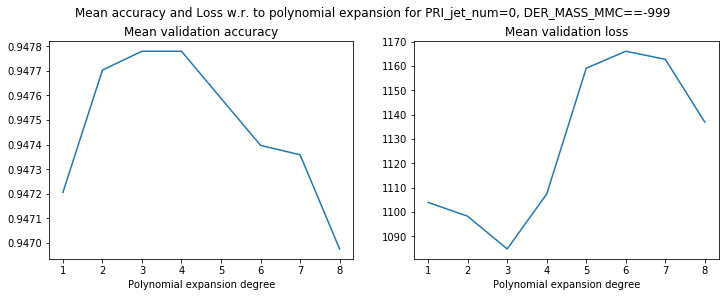

In [235]:
cross_validate_degrees(tX_0_nm, y_0_nm, headers, np.arange(1, 9), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC==-999")

In [258]:
degree_0_nm = 3

In [259]:
w_0_nm, matrix_0_nm = train_model(tX_0_nm, y_0_nm, headers, degree_0_nm, 0.75)

The 17 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet']

Performing polynomial expansion up to degree 3
Matrix has now 85 features
Gradient Descent(0/999): loss=44289.33774224323
Gradient Descent(100/999): loss=3200.17558680529
Gradient Descent(200/999): loss=3195.902776230051
Gradient Descent(300/999): loss=3195.725115805086
Gradient Descent(400/999): loss=3195.707885989037
Gradient Descent(500/999): loss=3195.706152300584
Gradient Descent(600/999): loss=3195.705975211292
Gradient Descent(700/999): loss=3195.705956716658
Gradient Descent(800/999): loss=3195.705954622306
Gradient Descent(900/999): loss=3195.705954311383
Regularized Logistic regression got score of 0.949318634206094, loss of 3195

### Category 1

/home/tarek/Documents/Master_DS/ML/ML_course/projects/project1/scripts/utils.py:50: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


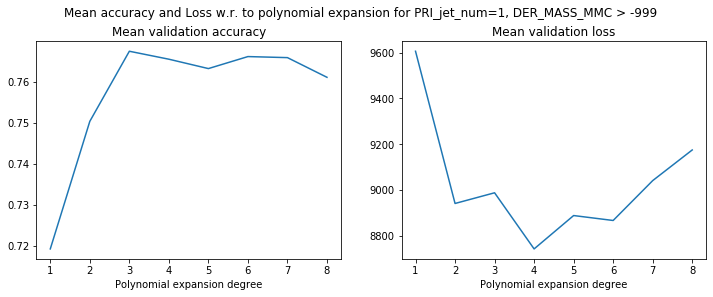

In [238]:
cross_validate_degrees(tX_1, y_1, headers, np.arange(1, 9), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [260]:
degree_1 = 4

In [261]:
w_1, matrix_1 = train_model(tX_1, y_1, headers, degree_1, 0.75)

The 22 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 4
Matrix has now 132 features
Gradient Descent(0/999): loss=167154.89223596826
Gradient Descent(100/999): loss=25734.721118153706
Gradient Descent(200/999): loss=25734.5857309631
Gradient Descent(300/999): loss=25734.585711988642
Gradient Descent(400/999): loss=25734.58571198592
Gradient Descent(500/999): loss=25734.585711985917
Gradient Descent(600/999): loss=25734.585711985917
Gradient Descent(700/999): loss=25734.585711985914
Gradient Descent(800/999): loss=25734.585711985914
Gradient Descent(900

### Category 1, no mass defined

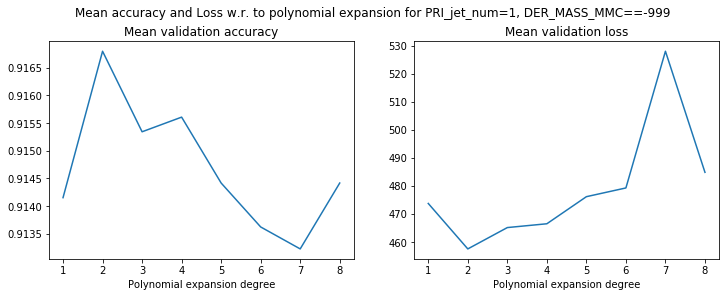

In [245]:
cross_validate_degrees(tX_1_nm, y_1_nm, headers, np.arange(1, 9), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC==-999")

In [262]:
degree_1_nm = 2

In [263]:
w_1_nm, matrix_1_nm = train_model(tX_1_nm, y_1_nm, headers, degree_1_nm, 0.75)

The 21 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 2
Matrix has now 84 features
Gradient Descent(0/999): loss=14755.858141851802
Gradient Descent(100/999): loss=1309.5448056962023
Gradient Descent(200/999): loss=1299.1807661459334
Gradient Descent(300/999): loss=1297.264095986663
Gradient Descent(400/999): loss=1296.3942577385828
Gradient Descent(500/999): loss=1295.965002746575
Gradient Descent(600/999): loss=1295.745766090048
Gradient Descent(700/999): loss=1295.631257810804
Gradient Descent(800/999): loss=1295.5705169520356
Gradient Descent(900/999): loss=1295.

### Category 2

/home/tarek/Documents/Master_DS/ML/ML_course/projects/project1/scripts/costs.py:32: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(xw))) - y.T.dot(xw)


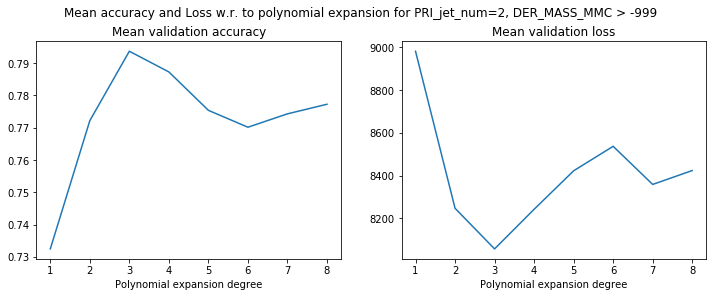

In [248]:
cross_validate_degrees(tX_2, y_2, headers, np.arange(1, 9), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=2, DER_MASS_MMC > -999")

In [264]:
degree_2 = 3

In [265]:
w_2, matrix_2 = train_model(tX_2, y_2, headers, degree_2, 0.75)

The 30 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 3
Matrix has now 150 features
Gradient Descent(0/999): loss=151394.31570945328
Gradient Descent(100/999): loss=24513.1030599904
Gradient Descent(200/999): loss=24355.91788931109
Gradient Descent(300/999): loss=24315.249461148836
Gradient Descent(400/999): loss=24302.097521617598
Gradient Descent(500/999): loss=24297.410984

### Category 2, no mass defined

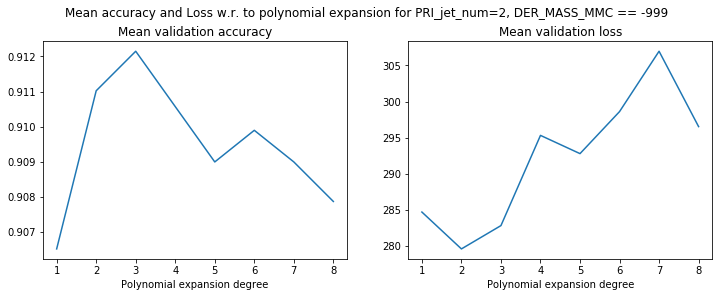

In [253]:
cross_validate_degrees(tX_2_nm, y_2_nm, headers, np.arange(1, 9), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=2, DER_MASS_MMC == -999")

In [266]:
degree_2_nm = 3

In [267]:
w_2_nm, matrix_2_nm = train_model(tX_2_nm, y_2_nm, headers, degree_2_nm, 0.75)

The 29 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 3
Matrix has now 145 features
Gradient Descent(0/999): loss=11056.14503455192
Gradient Descent(100/999): loss=855.7907496787069
Gradient Descent(200/999): loss=786.9942994476605
Gradient Descent(300/999): loss=778.4334614282534
Gradient Descent(400/999): loss=775.307114766374
Gradient Descent(500/999): loss=773.6816451943839
Gradient Des

## Generate predictions and save ouput in csv format for submission:

In [268]:
from data_processing import prepare_for_testing

In [269]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [270]:
def predict_testset(x, h, degrees, w, proj_mat):
    x,_ = enhance_features(x, h, degrees, proj_matrix=proj_mat, print_=False)
    x = prepare_for_testing(x)
    y_pred = predict_labels(w, x)
    return y_pred

In [271]:
tX_0_test, ids_0, tX_0_nm_test, ids_0_nm, tX_1_test, ids_1, tX_1_nm_test, ids_1_nm, tX_2_test, ids_2, tX_2_nm_test, ids_2_nm = split_dataset(tX_test, ids_test, jet_col=22, mass_col=0) # Split into each category

In [272]:
y_pred_0 = predict_testset(tX_0_test, headers, degree_0, w_0, matrix_0)
y_pred_0_nm = predict_testset(tX_0_nm_test, headers, degree_0_nm, w_0_nm, matrix_0_nm)

In [273]:
y_pred_1 = predict_testset(tX_1_test, headers, degree_1, w_1, matrix_1)
y_pred_1_nm = predict_testset(tX_1_nm_test, headers, degree_1_nm, w_1_nm, matrix_1_nm)

In [274]:
y_pred_2 = predict_testset(tX_2_test, headers, degree_2, w_2, matrix_2)
y_pred_2_nm = predict_testset(tX_2_nm_test, headers, degree_2_nm, w_2_nm, matrix_2_nm)

In [275]:
ids_test = np.concatenate([ids_0, ids_0_nm, ids_1, ids_1_nm, ids_2, ids_2_nm])
y_pred = np.concatenate([y_pred_0, y_pred_0_nm, y_pred_1, y_pred_1_nm, y_pred_2, y_pred_2_nm])

In [276]:
y_pred

array([[ 1.],
       [ 1.],
       [-1.],
       ...,
       [-1.],
       [-1.],
       [-1.]])

In [277]:
OUTPUT_PATH = 'test.csv' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights_ridge, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)